# Logic analysis


Hooking up the logic analyser to the `SPI` pins of `Hulk Board`, I captured various events.

The raw waveform look pretty clean and can be analysed to decipher the protocol in a practical environment. Here's a screenshot of the anlayser data:

![Logic Analyser Data](../data/media/power-cycle-logic-wf.png)


### Analysis goals

- Find the `LUT` table being sent. Specifically, we want the full LUT buffer from:

| Command    | Buffer |
|------------|-------:|
| LUT_KWVCOM |   32 B |
| LUT_KW     |  512 B |
| LUT_FT     |  128 B |

- Order of commands and correct power up/down sequences.
- Eventually, move to a hardware `SPI`, instead of bit-banging that sample code uses.




In [35]:
from pydash import py_

from tools import analyser

In [11]:
# Load the logic analyser data to the dataframe, and parse it:

df = analyser.load_logic_analysis('../data/logic-analysis/black-white-fill.csv')

edf = analyser.decode_dataframe(df)

In [14]:
# Show all the commands that were sent to the device.
# The analyser sets a `flag` to False if the data is interpreted as command.
# A command is identified by checking the bit value at `9`th MSB position.

# These were also decoded with the command name in datasheet as can be found in
# tools.consts module.

edf.query('flag==False')

,t,data,flag,cmd
0,2.3735,0x004,False,PON
1,2.4375,0x040,False,TSC
4,2.4658,0x020,False,LUT_KWVCOM
37,2.4689,0x022,False,LUT_KW
550,2.5179,0x026,False,LUT_FT
679,2.5302,0x014,False,DTMW
686,2.5309,0x016,False,
7887,3.2502,0x012,False,DRF
7895,3.8543,0x002,False,POF
7896,5.0392,0x004,False,PON


In [60]:
# Let's analyse an image data and attempt to get the actual image.

edf = (py_('../data/logic-analysis/slide-show.csv')
  .thru(analyser.load_logic_analysis)
  .thru(analyser.decode_dataframe)
  .value())

# Find all the commands
edf.query('flag==False')

# Note the row `DTMW` on index 679.
# This is where data write starts.
# Next few commands are gonna be used to set up parameters for displayed images.

edf[679:686]


,t,data,flag,cmd
679,3.4252,0x014,False,DTMW
680,3.4253,0x100,True,
681,3.4253,0x100,True,
682,3.4254,0x100,True,
683,3.4255,0x1EF,True,
684,3.4256,0x100,True,
685,3.4257,0x1EF,True,


### Interpretation of Data


```
t	data	flag	cmd
679	3.4252	0x014	False	DTMW
680	3.4253	0x100	True	     <-- Window X
681	3.4253	0x100	True	     <-- Window Y
682	3.4254	0x100	True	     
683	3.4255	0x1EF	True	     <-- Window Width; 0xEF = 240
684	3.4256	0x100	True	
685	3.4257	0x1EF	True	     <-- Window Length
```

In [148]:
edf = (py_('../data/logic-analysis/power-on-cycle.csv')
  .thru(analyser.load_logic_analysis)
  .thru(analyser.decode_dataframe)
  .value())

# Find all the commands
edf.query('flag==False').head()

,t,data,flag,cmd
0,0.3908,0x014,False,DTMW
7,0.3915,0x013,False,DTM2
14408,1.8391,0x040,False,TSC
14411,1.8673,0x020,False,LUT_KWVCOM
14444,1.8704,0x022,False,LUT_KW


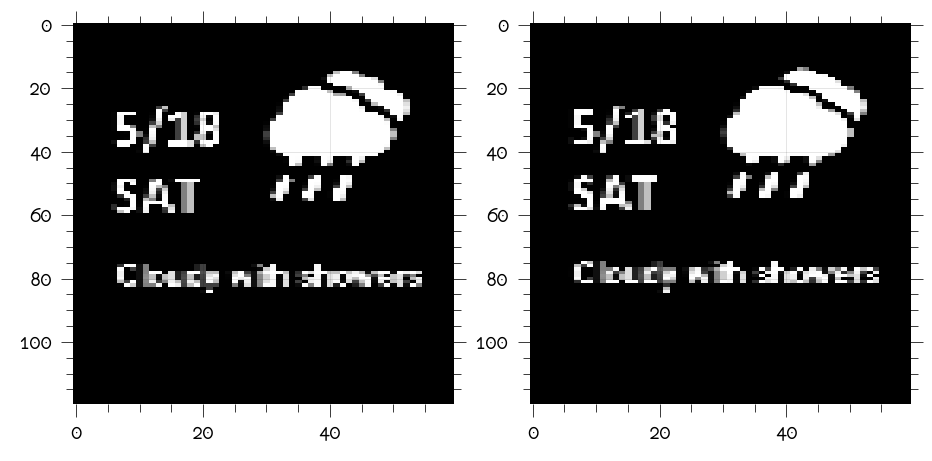

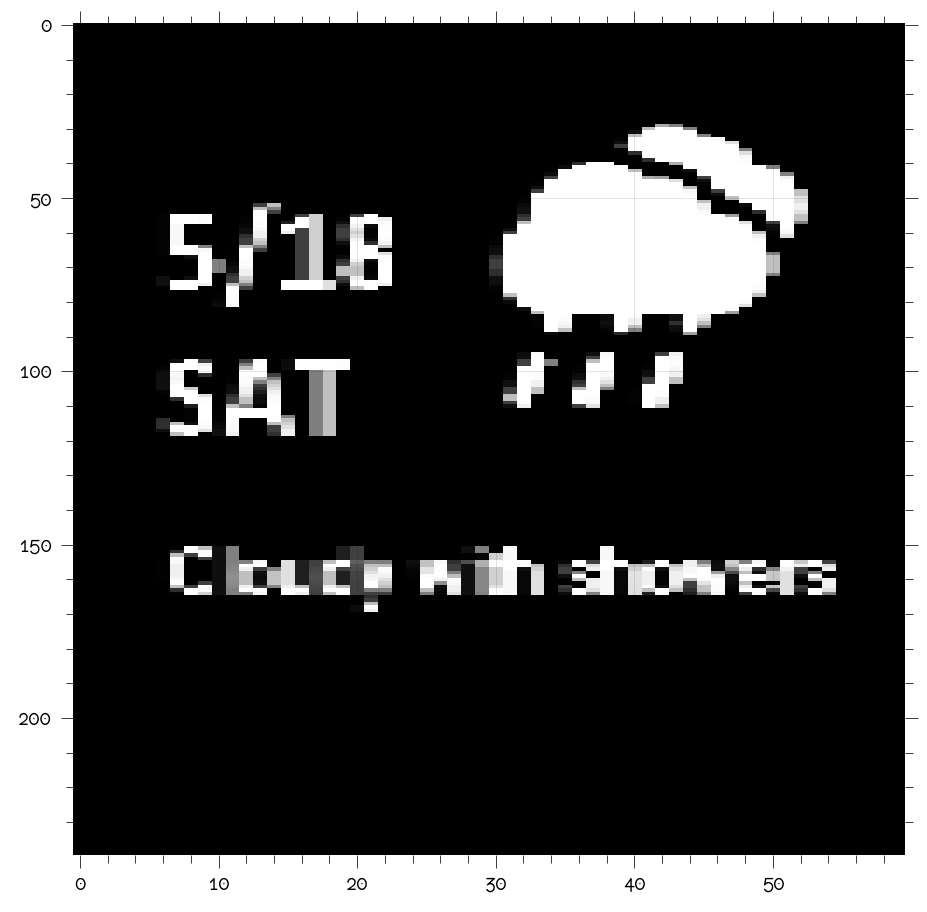

In [149]:
ix = edf[8:14408].data.str.replace('0x1', '').apply(lambda x: int(x, 16)).values.reshape(120, 120)

ix_a = ix[:,:60]
ix_b = ix[:,60:]

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(ix_a, aspect=0.5)
plt.subplot(122)
plt.imshow(ix_b, aspect=0.5)

# Trying to de-interlace the values
i_in = edf[8:14408].data.str.replace('0x1', '').apply(lambda x: int(x, 16)).values
plt.figure()
plt.imshow(i_in.reshape(240, 60), aspect=0.25)


In [135]:
edf = (py_('../data/logic-analysis/refresh-seq.csv')
  .thru(analyser.load_logic_analysis)
  .thru(analyser.decode_dataframe)
  .value())

edf.query('flag==False').head()

,t,data,flag,cmd
0,3.2080,0x014,False,DTMW
7,3.2087,0x013,False,DTM2
14408,4.6652,0x040,False,TSC
14411,4.6934,0x020,False,LUT_KWVCOM
14444,4.6965,0x022,False,LUT_KW


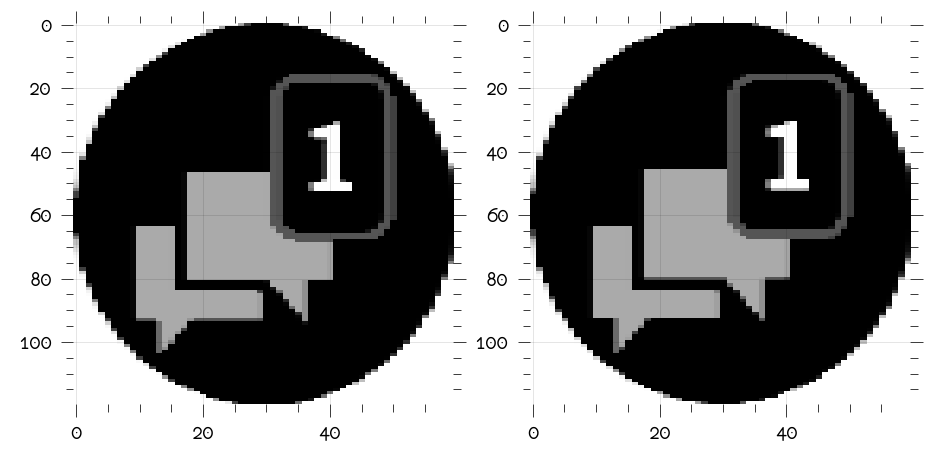

In [145]:
ix = edf[8:14408].data.str.replace('0x1', '').apply(lambda x: int(x, 16)).values.reshape(120, 120)

ix_a = ix[:,:60]
ix_b = ix[:,60:]


plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(ix_a, aspect=0.5)
plt.subplot(122)
plt.imshow(ix_b, aspect=0.5)